In [1]:
from ctrl import utils

# data = utils.generate_random_dataset(10, 50)
data = utils.load_data()

Calculate the Cumulative Impulse Respose (CIR) for EMI and social company

In [2]:
import numpy as np
from ctrl import discrete_optimal_control as doc

features = data[0]['Xlabs']
intervs = data[0]['Ilabs']
emi_CIR = np.zeros((len(data), len(intervs), len(features)))

for j in range(len(data)):
    A = data[j]['A']
    B = data[j]['B']
    for i in range(len(intervs)):
        emi_CIR[j,i] = doc.cumulative_impulse_response(A, B[:,i], 100)

Test the CIR of EMIs and social company against zero

In [3]:
from scipy import stats

print('Bonferroni corrected T Test results (corrected for 4 tests)')
ttest = stats.ttest_1samp(np.median(emi_CIR[:,0], axis=0), 0)
print(f'EMI-I: T={ttest.statistic}, p={ttest.pvalue*4}, df={ttest.df}')
ttest = stats.ttest_1samp(np.median(emi_CIR[:,1], axis=0), 0)
print(f'EMI-II: T={ttest.statistic}, p={ttest.pvalue*4}, df={ttest.df}')
ttest = stats.ttest_1samp(np.median(emi_CIR[:,2], axis=0), 0)
print(f'EMI-III: T={ttest.statistic}, p={ttest.pvalue*4}, df={ttest.df}')
ttest = stats.ttest_1samp(np.median(emi_CIR[:,3], axis=0), 0)
print(f'With company: T={ttest.statistic}, p={ttest.pvalue*4}, df={ttest.df}')

Bonferroni corrected T Test results (corrected for 4 tests)
EMI-I: T=-4.1498946544282935, p=0.003927073376937887, df=14
EMI-II: T=-6.552425486108697, p=5.143558727374632e-05, df=14
EMI-III: T=-1.9957405101597911, p=0.26318682497950724, df=14
With company: T=-1.5786453318854334, p=0.5469588620329617, df=14


Plot the CIR of EMIs and social company (Figure 2a)

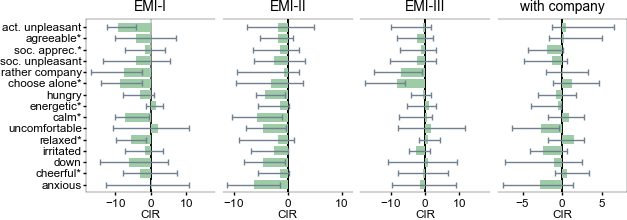

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import custom_rcparams_paper as crc

with mpl.rc_context({'ytick.labelsize':'small', 'figure.constrained_layout.wspace':0.05}):
    fig, axes = plt.subplots(1,len(intervs), figsize=(6.27,2.2), sharey=True)
    xlims = [(-5,5), (-5,5), (-10,10), (-5,5)]
    for i, ax in enumerate(axes):
        for j in range(len(features)):
            ax.barh(j, np.median(emi_CIR[:,i,j], axis=0), 
                    xerr=np.expand_dims([np.median(emi_CIR[:,i,j], axis=0) - np.percentile(emi_CIR[:,i,j], 25, axis=0), 
                                         np.percentile(emi_CIR[:,i,j], 75, axis=0) - np.median(emi_CIR[:,i,j], axis=0)], 1),
                    color=crc.colors.cir, ecolor=crc.colors.light_errorbars)
            ax.plot([0,0], ax.get_ylim(), color='black', zorder=-5, linewidth=0.25)
        xlim = np.max(np.abs(ax.get_xlim()))
        ax.set(xlabel='CIR',
            xlim=(-xlim, xlim),
            yticks=np.arange(len(features)),
            yticklabels=features,
            ylim=(-0.7, len(features)-0.3),
            title=intervs[i])
        if i>0:
            ax.spines[['left']].set_visible(False)
            ax.tick_params('y',left=False)
        if i<len(intervs)-1:
            ax.spines[['right']].set_visible(False)
    
    plt.savefig('figures/2a.png')

Calculate the CIR of hypothetical interventions on each individual node; also calculate their AC

In [5]:
node_AC = np.zeros((len(data), len(features)))
node_CIR = np.zeros((len(data), len(features), len(features)))
individual_highest_AC_node_CIR = np.zeros((len(data), len(features)))

for j in range(len(data)):
    A = data[j]['A']
    B = np.eye(A.shape[0])
    node_AC[j] = doc.average_ctrb(A, 15)    
    for i in range(len(features)):
        node_CIR[j,i] = doc.cumulative_impulse_response(A, -B[:,i], 100)

Find the nodes with highest AC for each individual subject

In [6]:
highest_median_ac = 11 #this is SOC. UNPLEASANT #np.argmax(np.median(ac, axis=0))
highest_individual_ac = np.argmax(node_AC, axis=1)
for i in range(len(data)):
    individual_highest_AC_node_CIR[i] = node_CIR[i, highest_individual_ac[i]]

Test the CIR of 'Social Unpleasant' and the individual max AC node against 0

In [7]:
from scipy import stats

print('Bonferroni corrected T Test results (corrected for 3 tests)')
ttest = stats.ttest_1samp(np.median(node_CIR[:,highest_median_ac], axis=0), 0)
print(f'High AC node: T={ttest.statistic}, p={ttest.pvalue*3}, df={ttest.df}')
ttest = stats.ttest_1samp(np.median(individual_highest_AC_node_CIR, axis=0), 0)
print(f'Individual highest AC node: T={ttest.statistic}, p={ttest.pvalue*3}, df={ttest.df}')

Bonferroni corrected T Test results (corrected for 3 tests)
High AC node: T=-2.765277595148157, p=0.04554739619809291, df=14
Individual highest AC node: T=-3.072756633139096, p=0.024803377538497, df=14


Test the CIR of 'Social Unpleasant' against the CIR of the individual max AC node

In [8]:
print('Comparison between high AC node and individual highest AC node')
ttest = stats.ttest_rel(np.median(node_CIR[:,highest_median_ac], axis=0), np.median(individual_highest_AC_node_CIR, axis=0))
print(f'AC comparison: T={ttest.statistic}, p={ttest.pvalue}, df={ttest.df}')

Comparison between high AC node and individual highest AC node
AC comparison: T=3.0375639970631574, p=0.008865883693307989, df=14


Plot the CIR of 'Social Unpleasant' and individual max AC node

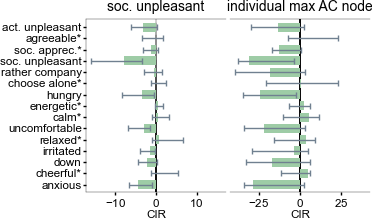

In [9]:
fig, axes = plt.subplots(1,2, figsize=(3.7,2.2), sharey=True)

ax = axes[0]
for j in range(len(features)):
    ax.barh(j, np.median(node_CIR[:,highest_median_ac,j], axis=0), 
        xerr=np.expand_dims([np.median(node_CIR[:,highest_median_ac,j], axis=0) - np.percentile(node_CIR[:,highest_median_ac,j], 25, axis=0), 
                np.percentile(node_CIR[:,highest_median_ac,j], 75, axis=0) - np.median(node_CIR[:,highest_median_ac,j], axis=0)], 1),
        color=crc.colors.cir, ecolor=crc.colors.light_errorbars)
    ax.plot([0,0], ax.get_ylim(), color='black', zorder=-5, linewidth=0.25)
xlim = np.max(np.abs(ax.get_xlim()))
ax.set(xlabel='CIR', 
    xlim=(-xlim, xlim),
    yticks=np.arange(len(features)),
    yticklabels=features,
    ylim=(-0.7, len(features)-0.3),
    title=features[highest_median_ac])
ax.spines[['right']].set_visible(False)

ax = axes[1]
for j in range(len(features)):
    median = np.median(individual_highest_AC_node_CIR[:,j], axis=0)
    percentile25 = np.percentile(individual_highest_AC_node_CIR[:,j], 25, axis=0)
    percentile75 = np.percentile(individual_highest_AC_node_CIR[:,j], 75, axis=0)
    ax.barh(j, median, 
        #     xerr = [median - percentile25, percentile75 - median],
            xerr=np.expand_dims([median - percentile25, percentile75 - median], 1),
            color=crc.colors.cir, ecolor=crc.colors.light_errorbars)
    ax.plot([0,0], ax.get_ylim(), color='black', zorder=-5, linewidth=0.25)
xlim = np.max(np.abs(ax.get_xlim()))
ax.set(xlabel='CIR', 
    xlim=(-xlim, xlim),
    yticks=np.arange(len(features)),
    yticklabels=features,
    ylim=(-0.7, len(features)-0.3),
    title='individual max AC node')
ax.spines[['left']].set_visible(False)
ax.tick_params('y',left=False)
ax.spines[['right']].set_visible(False)

fig.savefig('figures/2b.png')
plt.show()

Calculate the mean correlation between nodewise CIR and AC

In [21]:
from scipy.stats import pearsonr, sem
from custom_rcparams_paper import colors
import matplotlib as mpl

mean_corr = np.tanh(np.mean([np.arctanh(pearsonr(node_CIR.mean(2)[k], node_AC[k]).statistic) for k in range(node_CIR.shape[0])]))
sem_corr = np.tanh(sem([np.arctanh(pearsonr(node_CIR.mean(2)[k], node_AC[k]).statistic) for k in range(node_CIR.shape[0])]))

print(f'Mean over participants of correlation between nodewise AC and CIR: {mean_corr}, standard error {sem_corr}')

Mean over participants of correlation between nodewise AC and CIR: -0.501132049774072, standard error 0.23481545322353994


C:\Users\janik.fechtelpeter\AppData\Local\Temp\ipykernel_26488\3228420836.py:6: RuntimeWarning: invalid value encountered in log
  log_node_CIR = np.log(node_CIR)


Plot the relationship between nodewise CIR and log nodewise AC

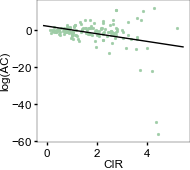

In [24]:
log_node_AC = np.log(node_AC)

with mpl.rc_context({'lines.markersize':2}):
    fig, ax = plt.subplots(figsize=(1.9,1.7))
    ax, _ = utils.plot_regression(log_node_AC.flatten(), node_CIR.mean(2).flatten(), ax=ax,
                        scatter_kwargs={'color':colors.cir}, line_kwargs={'color':'k'}, nan_policy='omit')
    ax.set(xlabel='CIR',
        ylabel='log(AC)',
        ylim=np.array(ax.get_ylim()) + np.array([-1, 1]))
    plt.savefig('figures/3c.png')

plt.show()